<center><img src="https://is1-ssl.mzstatic.com/image/thumb/Purple122/v4/05/e7/67/05e76784-3364-b535-7e20-b3f4946a56b6/AppIcon-0-0-1x_U007emarketing-0-0-0-7-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/434x0w.webp" style="height:150px"></center>

<hr style="border-width:2px;border-color:red">
<center><h1>Test Technique Data Scientist</h1></center>
<center><h2> Mesure de la dérive </h2></center>
<hr style="border-width:2px;border-color:red">

# Contexte

La **dérive** en apprentissage automatique (ou **"drift"** en anglais) fait référence à un **changement dans les données d'entrée ou de sortie d'un modèle** de machine learning **après son entraînement initial**. Cela peut se produire lorsque les données utilisées pour entraîner le modèle ne **reflètent plus la réalité**, ou lorsque **les conditions du problème changent de manière significative**.

La dérive des données peut affecter la précision du modèle de manière significative et peut entraîner des erreurs coûteuses dans les prévisions ou les décisions basées sur le modèle. Par conséquent, **il est important de surveiller régulièrement les performances du modèle** et de le mettre à jour en fonction des nouveaux jeux de données ou des nouvelles conditions du problème.

# Objectif

Dans ce test, vous allez implémenter des métriques permettant de mesurer la dérive d'un modèle dans un usecase de **e-commerce** où nous essayons de prédire le **panier total** (variable **`TotalCart`** : chiffre d'affaire total d'un client sur la période donnée) des clients en fonction des variables suivantes:
* **`Age`** : âge du client en années.
* **`Seniority`** : ancienneté du client en années.
* **`Orders`** : Nombre de commandes effectuées sur la période précédente.
* **`Items`** : Nombre d'items commandés sur la période précédente.
* **`AverageDiscount`** : Réduction moyenne accordée au client sur la période précédente en pourcentage.
* **`TopCategory`** : Catégorie de produits favorite du client.
* **`BrowsingTime`** : Temps total passé sur le site web sur la période précédente en secondes.
* **`EmailsOpened`** : Nombre de mails marketing ouverts par le client sur la période précédente.
* **`SupportInteractions`** : Nombre d'interactions que le client a eu avec le service client sur la période précédente.

Le jeu de données est décomposé en 4 périodes correspondant aux 4 trimestres de l'année 2022. Vous trouverez les données correspondant à chaque période dans les fichiers **`period_0.csv`**, **`period_1.csv`**, ..., **`period_3.csv`**.

Vous allez d'abord **entraîner et évaluer un modèle de machine learning** sur les données de la **période 0**. On supposera que ce modèle sera utilisé pour effectuer les prédictions de panier total sur toute l'année 2022.

Ensuite, vous devrez **implémenter des métriques de dérive** qui vous seront données et **effectuer une analyse** de celle-ci.

# Entraînement du modèle

* **Entraînez et validez** deux ou trois modèles de votre choix sur les données de la période 0. 

**Conseils**

* Vous serez évalué sur votre **rigueur** et non sur les performances du modèle.


* Il n'est pas nécessaire de faire une analyse exploratoire des données.


* Il n'est pas nécessaire de faire de recherche d'hyperparamètres optimaux non plus mais vous pouvez le faire si vous le souhaitez.


_______________________________________________________________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________________________________________________________

# Réponse

* Je commence par importer les bibliothèques que je vais utiliser dans tout ce test, et lire les fichiers period_i.csv

In [193]:
#Bibliothèques de Traitement de données
import pandas as pd
import numpy as np
import re

#Bibliothèques des modèles utiliser pour la prédictions
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#Bibliothèques utilisé pour la représentation graphique
import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
period_0 = pd.read_csv("./period_0.csv")
period_1 = pd.read_csv("./period_1.csv")
period_2 = pd.read_csv("./period_2.csv")
period_3 = pd.read_csv("./period_3.csv")

**Préparation des données - One Hot Encodig :** On remarque que les colonnes 'TopCtegory' contiennent entre 1 et 3 catégories.

Afin de bien interpréter cette colonne par les algorithmes, je remplace cette colonne par 17 autres colonnes correspondant à chaque catégorie mentionnée. Et pour chaque ligne je donne la valeur 1 aux catégories correspondantes et 0 aux autres.

In [195]:
#list de catégorie
topCategory_list = period_0['TopCategory'].tolist()
#séparer les données selon les séparateurs ',' et '&'
categories = set(sum([[x.replace(" ","") for x in re.split(',| &',c)] for c in topCategory_list], []))
#créer un dictionnaire vide 
d = { cat: np.zeros(1000, dtype = int) for cat in categories}

#créer d'autres tableau de données que je vais modifier
data_0=period_0.copy(deep=True)
data_1=period_1.copy(deep=True)
data_2=period_2.copy(deep=True)
data_3=period_3.copy(deep=True)


#la fonction one hot Encoding qui prend un tableau de données qui le renvoie avec les changements souhétés
def one_hot(data):
    #une fonction qui sépare les données selon les séparateurs ',' et '&'  ['a', 'b,c', 'd&e'] --> ['a', 'b', 'c', 'd', 'e']
    def str_to_list(x):
        res = re.split(',| &', x)
        #supprimer les éspaces
        res = [category.replace(" ", "") for category in res]
        return res

    # Appliquer cette dernière fonction à la colonne 'topCategories' 
    data['TopCategory'] = data['TopCategory'].apply(str_to_list)

    #Pour chaque catégorie éxistante par ligne : remplacer dans le 0 par 1
    for i,cats in enumerate(data['TopCategory']):
        for x in cats:
            d[x][i] = 1
    #transformer d en DataFrame
    one_hot_encoding = pd.DataFrame(d)

    #Concatener les deux tableaux
    data = pd.concat([data,one_hot_encoding], axis = 1)

    #Supprimer la colonne 'TopCatégory'
    data.drop(columns = ['TopCategory'], inplace = True)
    return data

#Appliquer les modifications aux quatre tableau de données
data_0 = one_hot(data_0)
data_1 = one_hot(data_1)
data_2 = one_hot(data_2)
data_3 = one_hot(data_3)

#Vérification
data_0

,Age,Seniority,Orders,Items,AverageDiscount,BrowsingTime,EmailsOpened,SupportInteractions,TotalCart,Health,...,Shoes,Clothing,PetSupplies,Electronics,BabyCare,Jewelry,Beauty,Household,PersonalCare,OfficeSupplies
0,21,2,4,7,0.14,68.473629,3,2,34.00,0,...,1,1,0,0,0,1,0,0,0,0
1,22,0,4,5,0.50,29.258063,1,0,28.28,0,...,0,0,0,0,0,0,0,0,0,0
2,22,1,2,6,0.37,11.515517,0,0,19.33,1,...,0,0,0,0,1,0,0,1,0,0
3,19,0,2,8,0.60,74.495861,1,0,26.83,0,...,0,0,0,0,0,0,0,0,0,0
4,25,1,1,5,0.58,1.682705,2,1,17.67,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,27,0,6,9,0.67,86.664343,1,1,46.65,0,...,1,1,0,0,0,1,0,0,0,0
996,30,0,4,7,0.40,365.542532,2,2,85.94,1,...,0,0,0,0,1,0,0,1,0,0
997,30,0,5,5,0.46,252.582605,0,0,71.69,0,...,0,0,0,0,0,0,1,0,1,0
998,23,0,1,8,0.66,3.329596,0,0,15.69,0,...,0,0,0,0,0,0,0,0,0,0


Dans la suite du test, je vais créer beaucoup de fonctions et afin de garder toujours les appeler par les mêmes paramètres "period_i":
* j'ai créé un nom correspondant à chaque période. 
* J'ai associé chaque "data_i" à sa "period_i" à l'aide d'une fonction et d'un dictionnaire.

In [196]:
period_0.name = 'period_0'
period_1.name = 'period_1'
period_2.name = 'period_2'
period_3.name = 'period_3'

dict = {'period_0': data_0,
        'period_1': data_1,
        'period_2': data_2,
        'period_3': data_3}

def period_to_data(period_i):
    return dict[period_i.name]


* **Entrainez votre modèle sur toute la période 0** puis **testez votre modèle** sur les données des **périodes 1, 2 et 3**. Comment évolue la performance du modèle?

### Entrainement des Modèles par la période 0

**Premier Modèle :** `Régression linéaire`

In [197]:
X = data_0.drop(columns=['TotalCart'])
y = data_0['TotalCart']

# Construction du  modèle Régression Linéaire
reg_model = LinearRegression()
reg_model.fit(X, y)

# Prédiction sur la période 0
y_pred_reg = reg_model.predict(X)

# Évaluation du modèle
score_reg = r2_score(y, y_pred_reg)
mse_reg = mean_squared_error(y_pred_reg, y)
mae_reg = mean_absolute_error(y, y_pred_reg)

# Affichage des résultats : coefficient R², Moyennes des erreurs aux carrée, Moyennes des erreurs absolues
print("Régression linéaire - Évaluation sur la période 0:")
print("MSE:", mse_reg)
print("MAE:", mae_reg)
print("R²:", score_reg)

Régression linéaire - Évaluation sur la période 0:
MSE: 63.103652542197544
MAE: 4.177052433812204
R²: 0.796521715849858


**Deuxième Modèle :** `Random Forest`

In [198]:
# Construction du modèle Random Forest
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X, y)


# Prédiction sur la période 0
y_pred_rf = random_forest_model.predict(X)


# Évaluation du modèle
score_RF= r2_score(y, y_pred_rf)
mse_RF = mean_squared_error(y, y_pred_rf)
mae_RF = mean_absolute_error(y, y_pred_rf)


# Affichage des résultats : coefficient R², Moyennes des erreurs aux carrée, Moyennes des erreurs absolues
print("Random Forest - Évaluation sur la période 0:")
print("MSE:", mse_RF)
print("MAE:", mae_RF)
print("R²:", score_RF)

Random Forest - Évaluation sur la période 0:
MSE: 0.7592767053999991
MAE: 0.5323581999999994
R²: 0.9975517055671753


**Troisième Modèle :** `XGBoost`

In [199]:
# Construction du modèle XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X, y)


# Prédiction sur les données de test
y_pred_xgb = xgb_model.predict(X)



# Calcul des métriques d'évaluation
score_xgb = r2_score(y, y_pred_xgb)
mse_xgb = mean_squared_error(y, y_pred_xgb)
mae_xgb = mean_absolute_error(y, y_pred_xgb)


# Affichage des résultats : coefficient R², Moyennes des erreurs aux carrée, Moyennes des erreurs absolues
print("XGBoost - Évaluation sur la période 0:")
print("MSE:", mse_xgb)
print("MAE:", mae_xgb)
print("R²:", score_xgb)


XGBoost - Évaluation sur la période 0:
MSE: 0.012484131821457311
MAE: 0.07666654954392932
R²: 0.9999597448068408


Enregistrement des résultats d'apprentissage 

In [200]:
#Création d'un dictionnare 'Résultats' où on va enregister (Score_R², MSE, MAE) pour chanque (periode, model)
Resultats={'period_0':{'Regression Lineaire':{},'Random Forest':{},'XGBoost':{}},'period_1':{'Regression Lineaire':{},'Random Forest':{},'XGBoost':{}},
'period_2':{'Regression Lineaire':{},'Random Forest':{},'XGBoost':{}},'period_3':{'Regression Lineaire':{},'Random Forest':{},'XGBoost':{}}}

In [201]:
#Enregistrement des données
#Reg
Resultats['period_0']['Regression Lineaire']['Score'] = round(score_reg,3)
Resultats['period_0']['Regression Lineaire']['MSE'] = round(mse_reg,3)
Resultats['period_0']['Regression Lineaire']['MAE'] = round(mae_reg,3)

#RF
Resultats['period_0']['Random Forest']['Score'] = round(score_RF,3)
Resultats['period_0']['Random Forest']['MSE'] = round(mse_RF,3)
Resultats['period_0']['Random Forest']['MAE'] = round(mae_RF,3)

#XGB
Resultats['period_0']['XGBoost']['Score'] = round(score_xgb,3)
Resultats['period_0']['XGBoost']['MSE'] = round(mse_xgb,3)
Resultats['period_0']['XGBoost']['MAE'] = round(mae_xgb,3)

### Test des Modèles sur les données des périodes 1, 2 et 3

In [202]:
#Encore une fois pour unifier les paramètres des prochaines fonctions, j'utilise une fonction qui fait reference aux modèle utliser

def model_name(mod):
    if mod == 'Regression Lineaire': return reg_model
    elif mod == 'Random Forest': return random_forest_model
    elif mod == 'XGBoost': return xgb_model
    else : return False

#enregister les prédictions dans un dictionnaire pour les utiliser dans les prochaines parties (calcul de proba et métriques)
prediction={'period_1':{'Regression Lineaire':{},'Random Forest':{},'XGBoost':{}},
'period_2':{'Regression Lineaire':{},'Random Forest':{},'XGBoost':{}},'period_3':{'Regression Lineaire':{},'Random Forest':{},'XGBoost':{}}}



def test(period, model):

    #Fonction de Prédiction 
    '''
        IN : 
            period : period_1, period_2 ou period_3
            model : 'Regression Lineaire', 'Random Forest' ou 'XGBoost'
        OUT :
            Résultats de la prédiction : R², MSE, MAE
    '''
    # Récuperer les données modifier 'One Hot Encodin' pour la période_i, et séparer ses donnée en X et y
    data = period_to_data(period)
    X = data.drop(columns=['TotalCart'])
    y = data['TotalCart']

    #vérification du nom du modèle
    if not model_name(model) : return "choisissez, svp, un des modèles suivants ( 'Regression Lineaire', 'Random Forest', 'XGBoost' )"

    else : 
        #prediction & Enregistrement des résultats
        mod = model_name(model)
        y_pred = mod.predict(X) 
        prediction[period.name][model] = y_pred

        #Calcul des résultats : coefficient R², Moyennes des erreurs aux carrée, Moyennes des erreurs absolues
        score = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)

        #Enregistrer les résultats
        Resultats[period.name][model]['Score'] = round(score,3)
        Resultats[period.name][model]['MSE'] = round(mse,3)
        Resultats[period.name][model]['MAE'] = round(mae,3)

        #Renvoyer les résultats
        return score, mse, mae

In [203]:
#Test et Affichage des résultats

for period in [period_1, period_2, period_3]:
    for model in ['Regression Lineaire', 'Random Forest', 'XGBoost']:
        test(period, model)
        


# Conversion du dictionnaire en DataFrame
Resultats_df = pd.DataFrame.from_dict(Resultats, orient='index')

print('Apprentissage Périod 0')
print(pd.DataFrame.from_dict(Resultats['period_0'], orient='index'))

print('\n','Test Périod 1')
print(pd.DataFrame.from_dict(Resultats['period_1'], orient='index'))

print('\n','Test Périod 2')
print(pd.DataFrame.from_dict(Resultats['period_2'], orient='index'))

print('\n','Test Périod 3')
print(pd.DataFrame.from_dict(Resultats['period_3'], orient='index'))

Apprentissage Périod 0
                     Score     MSE    MAE
Regression Lineaire  0.797  63.104  4.177
Random Forest        0.998   0.759  0.532
XGBoost              1.000   0.012  0.077

 Test Périod 1
                     Score      MSE    MAE
Regression Lineaire  0.674  115.282  8.474
Random Forest        0.816   65.149  7.602
XGBoost              0.816   64.894  7.673

 Test Périod 2
                     Score      MSE     MAE
Regression Lineaire  0.571  164.026  10.443
Random Forest        0.790   80.413   8.370
XGBoost              0.790   80.330   8.444

 Test Périod 3
                     Score      MSE     MAE
Regression Lineaire  0.364  347.914  15.405
Random Forest        0.695  166.870  11.397
XGBoost              0.706  160.599  11.368


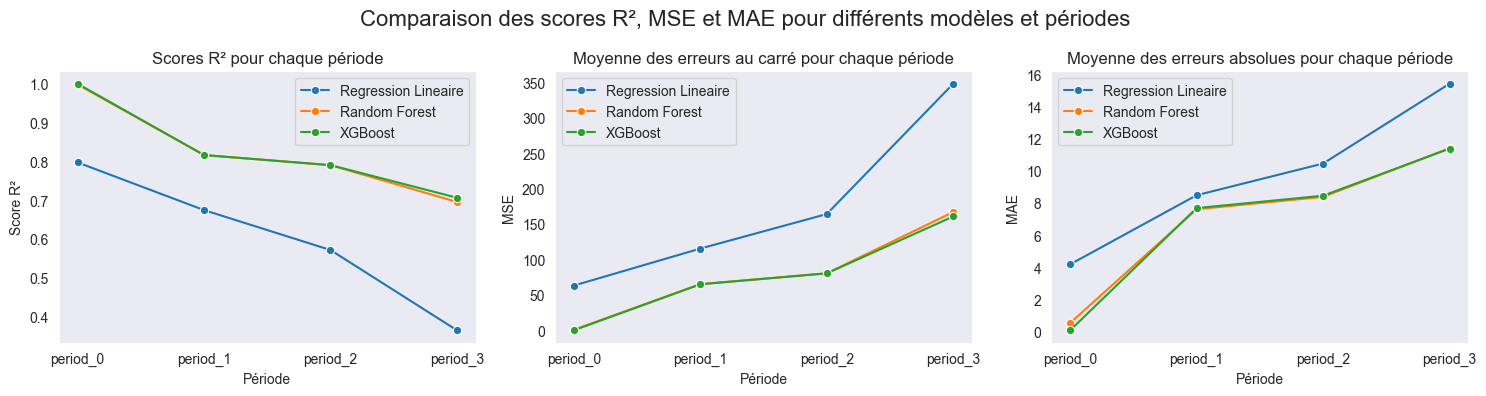

In [204]:
# Conversion en DataFrame
df_resultats = pd.DataFrame(Resultats).T.reset_index()
df_resultats.rename(columns={'index': 'Période'}, inplace=True)

# Création des sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Graphique R²
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['Regression Lineaire'].apply(lambda x: x['Score']), ax=axes[0], marker='o', label='Regression Lineaire')
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['Random Forest'].apply(lambda x: x['Score']), ax=axes[0], marker='o', label='Random Forest')
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['XGBoost'].apply(lambda x: x['Score']), ax=axes[0], marker='o', label='XGBoost')
axes[0].set_title('Scores R² pour chaque période')
axes[0].set_ylabel('Score R²')



# Graphique MSE
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['Regression Lineaire'].apply(lambda x: x['MSE']), ax=axes[1], marker='o', label='Regression Lineaire')
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['Random Forest'].apply(lambda x: x['MSE']), ax=axes[1], marker='o', label='Random Forest')
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['XGBoost'].apply(lambda x: x['MSE']), ax=axes[1], marker='o', label='XGBoost')
axes[1].set_title('Moyenne des erreurs au carré pour chaque période')
axes[1].set_ylabel('MSE')


# Graphique MAE
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['Regression Lineaire'].apply(lambda x: x['MAE']), ax=axes[2], marker='o', label='Regression Lineaire')
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['Random Forest'].apply(lambda x: x['MAE']), ax=axes[2], marker='o', label='Random Forest')
sns.lineplot(data=df_resultats, x='Période', y=df_resultats['XGBoost'].apply(lambda x: x['MAE']), ax=axes[2], marker='o', label='XGBoost')
axes[2].set_title('Moyenne des erreurs absolues pour chaque période')
axes[2].set_ylabel('MAE')

# Ajout de la ligne de titre
fig.suptitle("Comparaison des scores R², MSE et MAE pour différents modèles et périodes", fontsize=16)

# Ajustement de la disposition des graphiques avec le titre
plt.tight_layout()

# Affichage du graphique
plt.show()

## `Comparaison des performances des modèles sur différentes périodes`

**Nous pouvons comparer les modèles utilisés pour chaque période. Voici les résultats :**

* Pour la période 0, le modèle XGBoost obtient le meilleur score de 1.0, suivi du modèle Random Forest avec un score de 0.998, et enfin la Régression Linéaire avec un score de 0.797. Cela signifie que le modèle XGBoost explique le mieux les variations des données pour cette période.

* Pour la période 1, les modèles Random Forest et XGBoost ont des scores R² similaires de 0.815 et 0.816 respectivement, tandis que la Régression Linéaire obtient un score légèrement inférieur de 0.674. Cela suggère que Random Forest et XGBoost ont des performances similaires et légèrement meilleures que la Régression Linéaire pour cette période.

* Pour la période 2, tous les modèles ont des scores R² assez proches, avec XGBoost et Random Forest légèrement meilleurs que la Régression Linéaire. Cependant, la performance globale des modèles est relativement moins bonne pour cette période par rapport aux autres périodes.

* Pour la période 3, les résultats montrent que la Régression Linéaire obtient un score R² de 0.364, tandis que les modèles Random Forest et XGBoost obtiennent des scores R² de 0.695 et 0.706 respectivement. Cela indique que tous les modèles ont des performances inférieures par rapport aux périodes précédentes, avec la Régression Linéaire ayant la plus faible capacité à expliquer la variance des données pour cette période.

**En ce qui concerne les comparaisons entre les périodes pour chaque modèle :**

* Pour le modèle Régression Linéaire, le score R² diminue progressivement de la période 0 (0.797) à la période 3 (0.364). Cela suggère que ce modèle a plus de difficulté à expliquer les variations des données à mesure que les périodes avancent.

* Pour les modèles Random Forest et XGBoost, les scores R² restent relativement stables à travers les différentes périodes, avec de légères variations. Cela indique que ces modèles conservent leur capacité à expliquer les variations des données de manière cohérente, quelle que soit la période.

En résumé, les résultats montrent que XGBoost obtient généralement les meilleurs scores R² parmi les modèles pour chaque période. Cependant, il est important de noter que les performances des modèles peuvent varier d'une période à l'autre. Il peut être intéressant d'analyser plus en détail les résultats en examinant d'autres mesures d'erreur, telles que les erreurs quadratiques moyennes (MSE) et les erreurs absolues moyennes (MAE), pour évaluer la précision des prédictions et la capacité des modèles à minimiser les erreurs.
_______________________________________________________________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________________________________________________________

# Mesure de la dérive de variables catégorielles.

Pour deux distributions de probabilités discrètes $P$ et $Q$, la **divergence de Kullback–Leibler** de $P$ par rapport à $Q$ est définie par:

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$


On définit la **divergence de Jensen-Shannon** comme une version lisse et symétrique de la divergence de Kullback-Leiber donnée par la formule suivante:

$${\rm JSD}(P \parallel Q)= \frac{1}{2}D(P \parallel M)+\frac{1}{2}D(Q \parallel M)$$

où $M=\frac{1}{2}(P+Q)$

### Exemple de calcul de $D_\text{KL}(P \parallel Q)$ : 

Soient $P$ =`[0.2, 0.3, 0.5]` et $Q$ =`[0.2, 0.4, 0.4]` deux vecteurs définissant une loi de probabilité discrete. Alors : 

$$
\begin{equation}
\begin{split}
D_\text{KL}(P \parallel Q) & = P(0) \log\left(\frac{P(0)}{Q(0)}\right)
                             + P(1) \log\left(\frac{P(1)}{Q(1)}\right)
                             + P(2) \log\left(\frac{P(2)}{Q(2)}\right)\\ \\
                           & = 0.2 \log\left(\frac{0.2}{0.2}\right)
                             + 0.3 \log\left(\frac{0.3}{0.4}\right)
                             + 0.5 \log\left(\frac{0.5}{0.4}\right) \\ \\
                           & = 0.02526...
\end{split}
\end{equation}
$$

### Exercice

* Implémenter des fonctions nommées **`KLDivergence(P, Q)`** et **`JSDivergence(P, Q)`** permettant de calculer les métriques définies ci-dessus.

**Conseils**:
* Utiliser la librairie Numpy permettant de facilement effectuer des calculs d'algèbre linéaire.

In [205]:
P = np.array([0.2, 0.3, 0.5])
Q = np.array([0.2, 0.4, 0.4])

def KLDivergence(P, Q):
 
    # Domaine de déffinition de la fonction log: ]0, +inf[

    # remplacer les q=0 par q=eps
    # normaliser Q pour que sum(Q)=1
    if 0 in Q:
        eps = 1e-8
        Q = Q + eps
        
        #Q = Q / np.sum(Q) Est-ce qu'il faut normaliser ??

    #remplacer les P*np.log(P/Q) (pour p=0) par 0
    res = np.where(P!=0, P*np.log(P/Q), 0)
    return np.sum(res)



def JSDivergence(P, Q):
    
    # Insérez votre code ici
    M = (P+Q)/2
    return KLDivergence(P,M)/2 + KLDivergence(Q,M)/2
    

* Lancer la cellule suivante pour tester votre fonction.

In [206]:
print("K-L Divergence:", KLDivergence(P, Q))
print("J-S Divergence:", JSDivergence(P, Q))

K-L Divergence: 0.02526715392157057
J-S Divergence: 0.006367198333995731


# Mesure de la dérive de variables quantitatives.

Soit $P$ une mesure empirique d'échantillons $X_1, \ldots, X_n
$ et $Q$ une mesure empirique d'échantillons $Y_1, \ldots, Y_n$, on définit la **Distance de Wasserstein** d'ordre $p$ par la fonction suivante :

$$W_p(P, Q) = \left( \frac{1}{n}\sum_{i=1}^n \|X_{(i)} - Y_{(i)}\|^p \right)^{1/p}$$

où $X_{(1)}, \ldots, X_{(n)}$ et $Y_{(1)}, \ldots, Y_{(n)}$ sont les [**statistiques d'ordre**](https://en.wikipedia.org/wiki/Order_statistic#Notation_and_examples) des échantillons $X$ et $Y$ et $p$ un nombre entier positif.

### Exercice

* Implémenter une fonction nommée **`WassersteinDistance(X, Y, p)`** permettant de calculer cette métrique à l'ordre **`p`** à partir de **deux échantillons** **`X`** et **`Y`** que l'on supposera de même longueur.

**Conseils**:
* Vous pouvez trier les échantillons pour obtenir les statistiques d'ordre.

In [207]:
def WassersteinDistance(X, Y, p):
    
    sorted_X = np.sort(X)
    sorted_Y = np.sort(Y)

    S = np.sum(np.abs(sorted_X-sorted_Y)**p)
    n = len(X)

    return (S/n)**(1/p)
    

* Lancer la cellule suivante pour tester votre fonction.

In [208]:
X = np.random.beta(2, 6, 100)

Y = np.random.beta(3, 6, 100)

WassersteinDistance(X, Y, 2)

0.0811570413782135

# Étude de la dérive du modèle.

* En vous appuyant sur les métriques définies précédemment, illustrez et analysez visuellement la **dérive des données** ainsi que **la dérive du modèle** sur les périodes **1 à 3**. 


* Commenter les visualisations et déterminer si le modèle doit être mis à jour ou si sa performance est toujours acceptable. 

**Conseils**:
* Vous serez évalué sur **la rigueur et le soin** que vous donnerez à votre analyse, et sur **vos capacités à synthéthiser votre étude**. Vous ne serez pas évalué sur vos conclusions.


* Vous pouvez normaliser les données par rapport aux **moyennes et variances que vous calculerez sur la période 0** pour que les distances de Wasserstein pour différentes variables soient facilement comparables.

_______________________________________________________________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________________________________________________________

### `Réponses:`
* On commence par séparer les données entre données quantitatives et données catégorielles. ( Données Quantitatives sont : **'AverageDiscount'** et **'BrowsingTime'** + **'TotalCart'** )
* On passe à la normalisation des varibales quatitatives par les moyennes et les variances des données de la période 0. 
Pour chaque élement x des données qutitatives de period_i  $$ xi_{colonne} = \frac{xi_{colonne}-moyenne0_{colonne}}{\sqrt{Var0_{colonne}}} $$ avec $$i\in\{0,1,2,3\}$$

In [225]:
#normalisation 
moyenne_0_AD, variance_0_AD = np.mean(list(data_0['AverageDiscount'])), np.var(list(data_0['AverageDiscount']))
moyenne_0_BT, variance_0_BT = np.mean(list(data_0['BrowsingTime'])), np.var(list(data_0['BrowsingTime']))
moyenne_0_y, variance_0_y = np.mean(list(data_0['TotalCart'])), np.var(list(data_0['TotalCart']))

def separation(period_i):
    data = period_to_data(period_i)

    #separation des données
    data_quantitavies = pd.DataFrame()
    
    #normalisation
    data_quantitavies['AverageDiscount'] = data['AverageDiscount'].apply(lambda x: (x-moyenne_0_AD)/np.sqrt(variance_0_AD))
    data_quantitavies['BrowsingTime'] = data['BrowsingTime'].apply(lambda x: (x-moyenne_0_BT)/np.sqrt(variance_0_BT))
    data_quantitavies['TotalCart'] = data['TotalCart'].apply(lambda x: (x-moyenne_0_y)/np.sqrt(variance_0_y))

    data_categorielles = data.drop(columns=['AverageDiscount','BrowsingTime', 'TotalCart'])

    return data_categorielles, data_quantitavies 


**`Calcul des Dérives des Données et des Prédictions`**

In [249]:
##=========================Dérive Des Données===========================
data_0_c, data_0_q = separation(period_0)

##Calcule des dérives
def derive_data(period_i):

    #séparation des données
    data_c, data_q = separation(period_i)
    kl_derive, js_derive = {},{}
    wasserstein_dist = {}

    #Données catégorielles
    for colonne in data_c.columns:
        
        #list des catégories 
        categories = list(set(list(set(data_0_c[colonne]))+list(data_c[colonne])))

        col = list(data_c[colonne])
        col_0 = list(data_0_c[colonne])
        
        # Calcul des probabilités empiriques pour les périodes 0 et i 'data_catégorielle'
        period_0_proba = np.array([col_0.count(category) / len(col_0) for category in categories])
        period_i_proba = np.array([col.count(category) / len(col) for category in categories])

        # Calcul des métriques de divergence pour les variables catégorielles
        kl_divergence = KLDivergence(period_i_proba, period_0_proba)
        js_divergence = JSDivergence(period_i_proba, period_0_proba)

        #Enregistrer les résultats
        kl_derive[colonne] = kl_divergence
        js_derive[colonne] = js_divergence

    #Données Quantitave
    for colonne in data_q.columns:
        
        col = list(data_q[colonne])
        col_0 = list(data_0_q[colonne])

        #Calcul de la Distance de Wasserstein pour les données quantitative d'ordre p=2 (à changer) 
        wasserstein = WassersteinDistance(col, col_0, p=2)

        wasserstein_dist[colonne] = wasserstein

    return kl_derive, js_derive, wasserstein_dist


In [250]:
##=========================Dérive Des Modèles===========================
#Les prédiction de 'TotalCart' sont des variables quantitave ==> On calcule la Distance de Wasserstein

wasserstein_dist_modeles = {'period_0': {}, 'period_1': {}, 'period_2': {}, 'period_3': {}}
List_0_TC = (list(data_0['TotalCart']) - moyenne_0_y)/np.sqrt(variance_0_y)

def derive_model():
    #premier calcule pour les résultats d'entrainement -period_0-

    #normalisation
    
    y_pred_reg2 = (y_pred_reg - moyenne_0_y)/np.sqrt(variance_0_y)
    y_pred_rf2 = (y_pred_rf - moyenne_0_y)/np.sqrt(variance_0_y) 
    y_pred_xgb2 = (y_pred_xgb - moyenne_0_y)/np.sqrt(variance_0_y)

    wasserstein_reg = WassersteinDistance(List_0_TC, y_pred_reg2, p=2)
    wasserstein_rf = WassersteinDistance(List_0_TC, y_pred_rf2, p=2)
    wasserstein_xgb = WassersteinDistance(List_0_TC, y_pred_xgb2, p=2)

    wasserstein_dist_modeles['period_0']['Regression Lineaire'] = wasserstein_reg
    wasserstein_dist_modeles['period_0']['Random Forest'] = wasserstein_rf
    wasserstein_dist_modeles['period_0']['XGBoost'] = wasserstein_xgb
    
    #Calcule pour les predictions des autres periodes

    for p in [period_1, period_2, period_3]: 
        for model in ['Regression Lineaire', 'Random Forest', 'XGBoost']:

            #Appel et Normalisation des predictions de chaque modèle pour chaque périod
            y_pred = prediction[p.name][model]
            y_pred = (y_pred - moyenne_0_y)/np.sqrt(variance_0_y)

            #Calcule de la disttance de Wasserstein
            wasserstein = WassersteinDistance(List_0_TC, y_pred, p=2)
            wasserstein_dist_modeles[p.name][model] = wasserstein

    return wasserstein_dist_modeles


In [251]:
#Utilisation des fontions précedentes pour le calcul

KL_divergence, JS_divergence, Wasserstein_distance ={}, {}, {}

for period in [period_1, period_2, period_3]:
    KL_divergence[period.name], JS_divergence[period.name], Wasserstein_distance[period.name] = derive_data(period)


#Enregistrement des Résultats

Resultats_DLK = pd.DataFrame.from_dict(KL_divergence, orient='index')
Resultats_JSD = pd.DataFrame.from_dict(JS_divergence, orient='index')
Resultats_WD = pd.DataFrame.from_dict(Wasserstein_distance, orient='index')
Resultats_WD_pred = pd.DataFrame.from_dict(derive_model(), orient='index')

C:\Users\abdel\AppData\Local\Temp\ipykernel_47420\54416598.py:17: RuntimeWarning: divide by zero encountered in log
  res = np.where(P!=0, P*np.log(P/Q), 0)
C:\Users\abdel\AppData\Local\Temp\ipykernel_47420\54416598.py:17: RuntimeWarning: invalid value encountered in multiply
  res = np.where(P!=0, P*np.log(P/Q), 0)
C:\Users\abdel\AppData\Local\Temp\ipykernel_47420\54416598.py:17: RuntimeWarning: divide by zero encountered in log
  res = np.where(P!=0, P*np.log(P/Q), 0)
C:\Users\abdel\AppData\Local\Temp\ipykernel_47420\54416598.py:17: RuntimeWarning: invalid value encountered in multiply
  res = np.where(P!=0, P*np.log(P/Q), 0)
C:\Users\abdel\AppData\Local\Temp\ipykernel_47420\54416598.py:17: RuntimeWarning: divide by zero encountered in log
  res = np.where(P!=0, P*np.log(P/Q), 0)
C:\Users\abdel\AppData\Local\Temp\ipykernel_47420\54416598.py:17: RuntimeWarning: invalid value encountered in multiply
  res = np.where(P!=0, P*np.log(P/Q), 0)


In [252]:
Resultats_DLK 

,Age,Seniority,Orders,Items,EmailsOpened,SupportInteractions,Health,Kitchen,Games,Sports,...,Shoes,Clothing,PetSupplies,Electronics,BabyCare,Jewelry,Beauty,Household,PersonalCare,OfficeSupplies
period_1,0.083427,0.028409,0.043270,0.091587,0.008139,0.009176,0.039925,0.035854,0.066631,0.021259,...,0.101998,0.101998,0.002231,0.028223,0.039925,0.101998,0.061686,0.039925,0.061686,0.002859
period_2,0.079390,0.143895,0.076150,0.173896,0.008711,0.005502,0.133459,0.108872,0.222311,0.052363,...,0.265114,0.265114,0.011827,0.093060,0.133459,0.265114,0.194800,0.133459,0.194800,0.005064
period_3,0.098512,0.330171,0.190684,0.323397,0.006623,0.006775,0.267445,0.182556,0.372958,0.101034,...,0.423272,0.423272,0.020509,0.196600,0.267445,0.423272,0.343976,0.267445,0.343976,0.007676


In [253]:
Resultats_JSD

,Age,Seniority,Orders,Items,EmailsOpened,SupportInteractions,Health,Kitchen,Games,Sports,...,Shoes,Clothing,PetSupplies,Electronics,BabyCare,Jewelry,Beauty,Household,PersonalCare,OfficeSupplies
period_1,0.013348,0.006738,0.006305,0.009551,0.002284,0.002373,0.008995,0.008393,0.015353,0.004318,...,0.023858,0.023858,0.000503,0.006154,0.008995,0.023858,0.014725,0.008995,0.014725,0.000593
period_2,0.017589,0.027613,0.020419,0.021153,0.002401,0.001514,0.028347,0.024655,0.049418,0.009786,...,0.061207,0.061207,0.002396,0.018733,0.028347,0.061207,0.045903,0.028347,0.045903,0.001000
period_3,0.022473,0.053310,0.049250,0.052483,0.001919,0.001779,0.054719,0.040679,0.082067,0.017575,...,0.097974,0.097974,0.003952,0.037249,0.054719,0.097974,0.081292,0.054719,0.081292,0.001456


In [254]:
Resultats_WD

,AverageDiscount,BrowsingTime,TotalCart
period_1,0.115604,0.177017,0.370324
period_2,0.265712,0.291597,0.447100
period_3,0.320564,0.656073,0.715961


In [255]:
Resultats_WD_pred

,Regression Lineaire,Random Forest,XGBoost
period_0,0.188025,0.030340,0.003333
period_1,0.214098,0.146851,0.147222
period_2,0.272160,0.251732,0.251243
period_3,0.459494,0.454375,0.447570


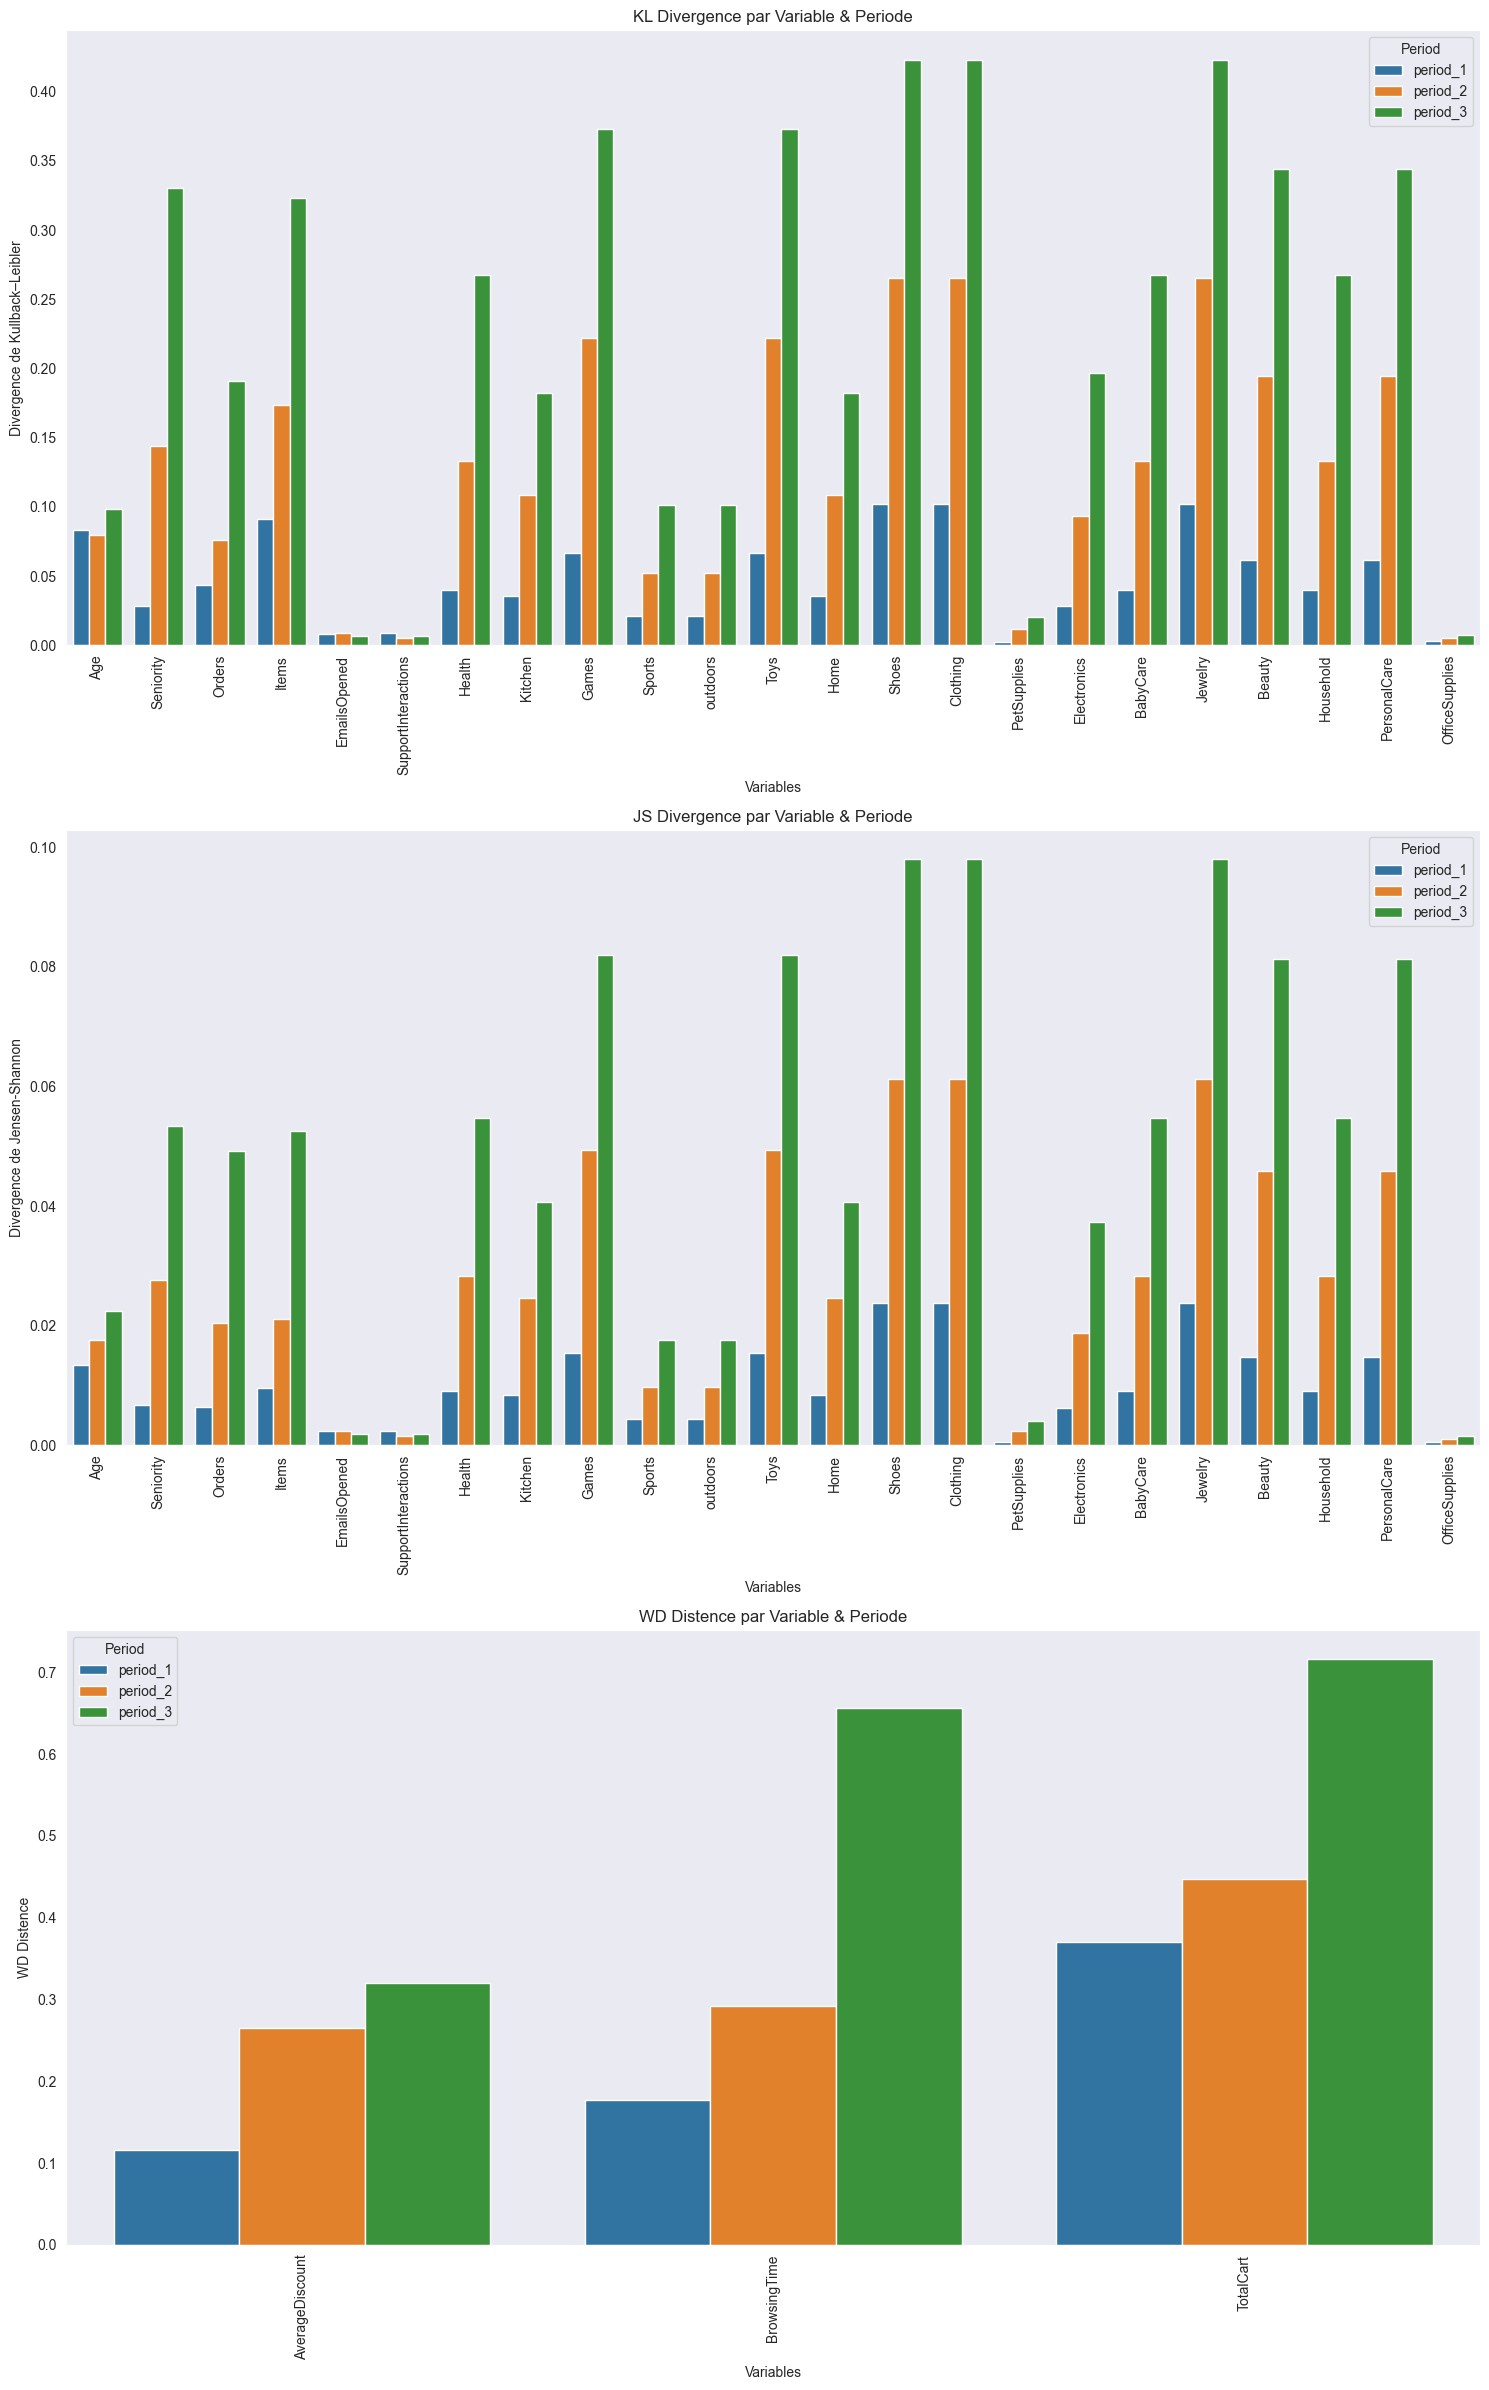

In [256]:
# 1- Données de la divergence KL pour chaque période
# Liste des variables (abscisses)
variables_1 = Resultats_DLK.columns.tolist()

# Liste des périodes
periods_1 = Resultats_DLK.index.tolist()

# Création d'un nouveau DataFrame pour les données à tracer
data_1 = []
for variable in variables_1:
    for i, period in enumerate(periods_1):
        kl_value = Resultats_DLK.loc[period, variable]
        data_1.append({'Variable': variable, 'KL Divergence': kl_value, 'Period': period})
data_df_1 = pd.DataFrame(data_1)

# Configurer le style de Seaborn
sns.set_style("dark")

# Création de la figure et des axes
fig, ax = plt.subplots(3, 1, figsize=(15, 24))

# Tracé du premier graphique (KL Divergence)
sns.barplot(data=data_df_1, x='Variable', y='KL Divergence', hue='Period', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_xlabel('Variables')
ax[0].set_ylabel('Divergence de Kullback–Leibler')
ax[0].set_title('KL Divergence par Variable & Periode')



# 2- Données de la divergence JS pour chaque période
# Liste des variables (abscisses)
variables_2 = Resultats_JSD.columns.tolist()

# Liste des périodes
periods_2 = Resultats_JSD.index.tolist()

# Création d'un nouveau DataFrame pour les données à tracer
data_2 = []
for variable in variables_2:
    for i, period in enumerate(periods_2):
        kl_value = Resultats_JSD.loc[period, variable]
        data_2.append({'Variable': variable, 'JS Divergence': kl_value, 'Period': period})
data_df_2 = pd.DataFrame(data_2)

# Tracé du deuxième graphique (JS Divergence)
sns.barplot(data=data_df_2, x='Variable', y='JS Divergence', hue='Period', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_xlabel('Variables')
ax[1].set_ylabel('Divergence de Jensen-Shannon')
ax[1].set_title('JS Divergence par Variable & Periode')

# 3-  Données de la distance WD pour chaque période
# Liste des variables (abscisses)
variables_3 = Resultats_WD.columns.tolist()

# Liste des périodes
periods_3 = Resultats_WD.index.tolist()

# Création d'un nouveau DataFrame pour les données à tracer
data_3 = []
for variable in variables_3:
    for i, period in enumerate(periods_3):
        kl_value = Resultats_WD.loc[period, variable]
        data_3.append({'Variable': variable, 'WD Distence': kl_value, 'Period': period})
data_df_3 = pd.DataFrame(data_3)

# Tracé du troisième graphique (WD Distence)
sns.barplot(data=data_df_3, x='Variable', y='WD Distence', hue='Period', ax=ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
ax[2].set_xlabel('Variables')
ax[2].set_ylabel('WD Distence')
ax[2].set_title('WD Distence par Variable & Periode')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()


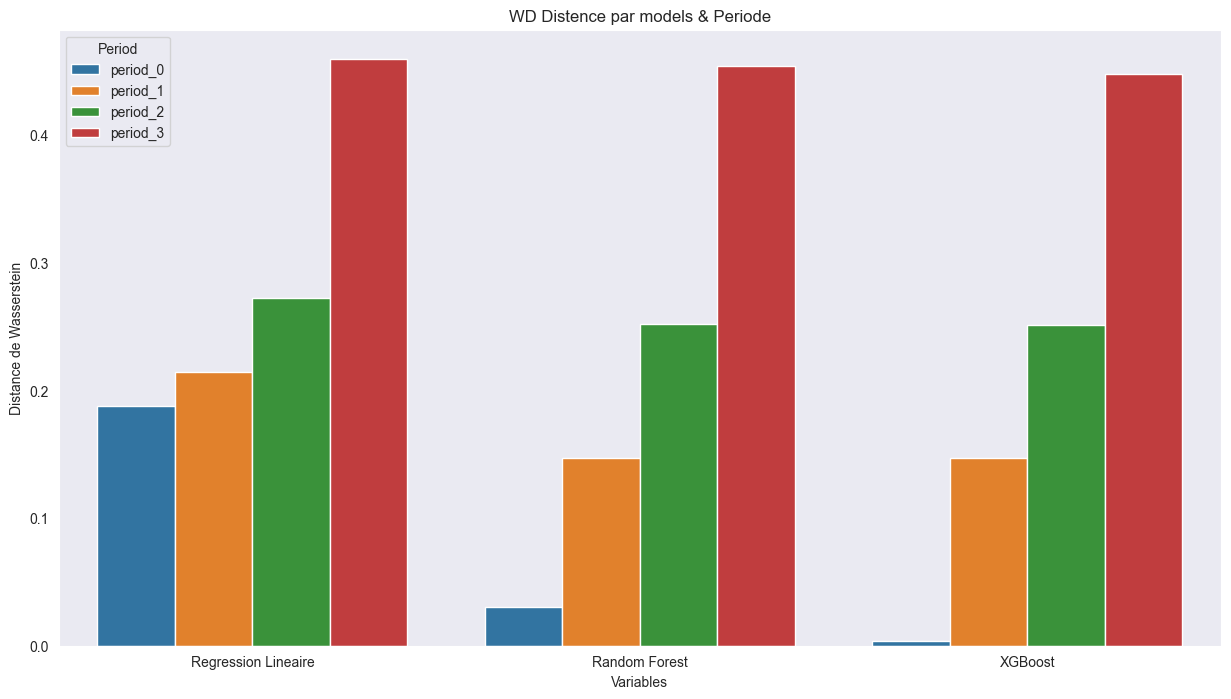

In [257]:
# Liste des variables (abscisses)
variables = Resultats_WD_pred.columns.tolist()

# Liste des périodes
periods = Resultats_WD_pred.index.tolist()
plt.figure(figsize=(15, 8))
# Création d'un nouveau DataFrame pour les données à tracer
data = []
for variable in variables:
    for i, period in enumerate(periods):
        kl_value = Resultats_WD_pred.loc[period, variable]
        data.append({'Variable': variable, 'WD Distence models': kl_value, 'Period': period})
data_df = pd.DataFrame(data)
# Configurer le style de Seaborn
sns.set_style("dark")
# Tracé des rectangles pour chaque période
sns.barplot(data=data_df, x='Variable', y='WD Distence models', hue='Period')



# Configuration des axes
plt.xlabel('Variables')
plt.ylabel('Distance de Wasserstein')
plt.title('WD Distence par models & Periode')

# Affichage du graphique
plt.show()

<h1>Dernière partie : interprétation des résultats </h1>

D'après les résultats obtenus :

* Les métriques KLD et JSD montrent que les différences entre les périodes sont relativement faibles. Les valeurs se situent généralement en dessous de 0.4 et 0.1 respectivement. Cela suggère que les périodes ont des distributions de données similaires ou cohérentes.

* En ce qui concerne les données catégorielles, la distance de Wasserstein (WD) montre une plus grande variation, allant jusqu'à 0.7. Cela indique une plus grande différence entre les périodes en termes de répartition des catégories.

* Les valeurs de WD entre les prédictions des modèles sur chaque période sont également relativement faibles, avec une valeur maximale de 0.5. Cela suggère une cohérence acceptable entre les prédictions des modèles pour différentes périodes.

En se basant sur ces résultats, on peut conclure que le modèle présente une performance globalement acceptable. Il y a cependant une certaine variation entre les périodes en termes de distribution des données et de prédictionspour la période 3. Si ces variations restent acceptables et n'affectent pas l'objectif ou la qualité du modèle, il peut ne pas être nécessaire de le mettre à jour.

Si nous souhaitons améliorer nos résultats, il serait judicieux de prendre en considération la mise à jour des données de la période 3. Cela pourrait permettre d'atténuer les variations de distribution observées entre les périodes et potentiellement améliorer nos prédictions. Par ailleurs, il pourrait être intéressant d'explorer l'utilisation et l'optimisation de modèles de Deep Learning alternatifs. Ces approches pourraient apporter des améliorations subtiles à nos prédictions malgré les différences de distribution des données.
